## Hazard assessment for Precipitation: Percentiles and return levels of extreme precipitation

In [2]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import xarray as xr

from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter)
from datetime import datetime, timedelta
from regionmask import mask_geopandas
from matplotlib.colors import ListedColormap
from matplotlib import colors

ERROR 1: PROJ: proj_create_from_database: Open of /work/cmcc/dg07124/miniconda3/envs/climax/share/proj failed


This notebook processes NetCDF files containing data about the percentiles of extreme precipitation (percentiles 99, 99.5 and 99.9) and generates maps visualizing the values of precipitation over Italy for these percentiles.

- We load a shapefile of Europe, then we isolate the portion of the shapefile that corresponds to Italy.
- We search for the *indicators_path* for all NetCDF files that start with 'Precip_P', which contain files corresponding to the percentiles.
These files are sorted for further processing.

In [3]:
# Path to the folder containing the NetCDF files
indicators_path = '/work/cmcc/dg07124/climax/indicators/uerra'
output_maps = r'/work/cmcc/dg07124/climax/indicators/uerra/maps'

# Read the shapefile for Italy
gdf = gpd.read_file('/work/cmcc/dg07124/climax/data/shp/EU/CNTR_RG_01M_2020_4326.shp')
italy = gdf[gdf.NAME_ENGL == 'Italy']

# Find all files in the directory that start with 'NumbDays'
file_pattern = os.path.join(indicators_path, 'Precip_P*.nc')
Precip_Percentile_files = sorted(glob.glob(file_pattern))
print(Precip_Percentile_files)

['/work/cmcc/dg07124/climax/indicators/Precip_P95.nc', '/work/cmcc/dg07124/climax/indicators/Precip_P995.nc', '/work/cmcc/dg07124/climax/indicators/Precip_P999.nc']


In [4]:
# List to store masked data
masked_PrecipPercentile_arrays = []
# Define variable name
variable_name = 'tp'

# Loop through each NetCDF file, mask the data, and store the results
for Precip_Percentile_file in Precip_Percentile_files:
    # Open dataset
    ds_Precip_Percentile = xr.open_dataset(Precip_Percentile_file)

    # Extract the variable of interest
    var = ds_Precip_Percentile[variable_name]
    lon = ds_Precip_Percentile['longitude']
    lat = ds_Precip_Percentile['latitude']

    # Create the mask
    mmask = mask_geopandas(italy, lon, lat) * 0 + 1

    # Apply the mask to the dataset
    masked_PrecipPercentile = var * mmask
    masked_PrecipPercentile_arrays.append(masked_PrecipPercentile)

# Find the global min and max values across all masked data arrays for consistent color scaling
global_min_PrecipPercentile = np.nanmin([np.nanmin(PrecipPercentile.values) for PrecipPercentile in masked_PrecipPercentile_arrays])
global_max_PrecipPercentile = np.nanmax([np.nanmax(PrecipPercentile.values) for PrecipPercentile in masked_PrecipPercentile_arrays])
print(f"Global min: {global_min_PrecipPercentile}, Global max: {global_max_PrecipPercentile}")

Global min: 14.57421875, Global max: 139.35156250000176


## Maps of Percentiles 99, 99.5 and 99.9 of Precipitation

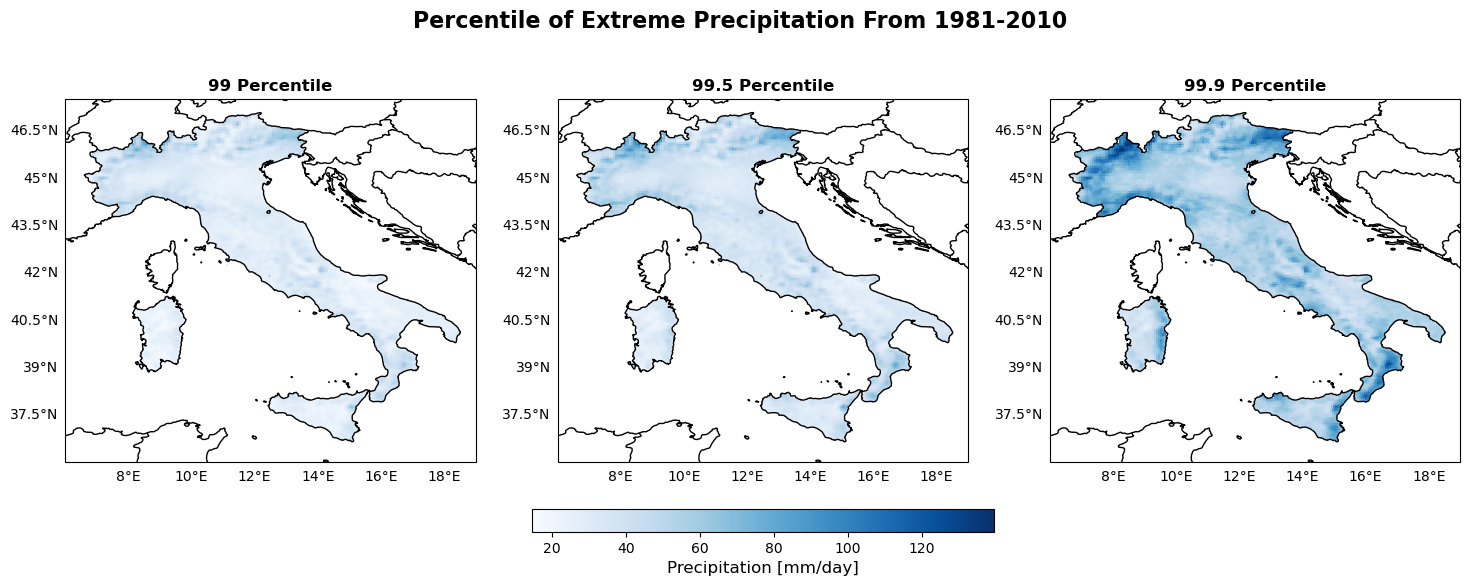

In [7]:
# Titles for the plots
titles_PrecipPercentiles = ['99 Percentile', '99.5 Percentile', '99.9 Percentile']

# Create the figure and axis for plotting (1 row, 3 columns)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Loop through each masked data array and plot
for i, (masked_PrecipPercentile_array, ax, title_PrecipPercentiles) in enumerate(zip(masked_PrecipPercentile_arrays, axes, titles_PrecipPercentiles)):
    # Add geographical features
    # ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'))
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black')
    # Add gridlines and format
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.0)
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LongitudeFormatter()
    gl.yformatter = LatitudeFormatter()

    # Plot the masked data
    im = ax.pcolormesh(masked_PrecipPercentile_array['longitude'], masked_PrecipPercentile_array['latitude'], masked_PrecipPercentile_array.values, cmap='Blues', vmin=global_min_PrecipPercentile, vmax=global_max_PrecipPercentile, transform=ccrs.PlateCarree())

    # Set title
    ax.set_title(title_PrecipPercentiles, fontweight='bold')

    # Set extent to focus on Italy
    ax.set_extent([6.0, 19.0, 36.0, 47.5], crs=ccrs.PlateCarree())

# Add a colorbar for all plots
cbar = fig.colorbar(im, ax=axes, orientation='horizontal', fraction=0.05, pad=0.1)
cbar.set_label('Precipitation [mm/day]', fontsize=12)
fig.suptitle('Percentile of Extreme Precipitation From 1981-2010', fontsize=16, fontweight='bold')
output_fig_path = os.path.join(output_maps, f"UERRA_percentile_comparison.png")
plt.savefig(output_fig_path)
plt.show()

## Maps of Return Levels based on the Return Periods 10, 20, 30, 50, 100, 150 years

In [15]:
return_ds = xr.open_dataset('/work/cmcc/dg07124/climax/indicators/uerra/return_levels_gumbel.nc')
return_ds

<xarray.Dataset> Size: 4MB
Dimensions:              (y: 238, x: 233)
Coordinates:
    longitude            (y, x) float64 444kB ...
    latitude             (y, x) float64 444kB ...
    time                 datetime64[ns] 8B ...
  * x                    (x) int64 2kB 0 1 2 3 4 5 6 ... 227 228 229 230 231 232
  * y                    (y) int64 2kB 0 1 2 3 4 5 6 ... 232 233 234 235 236 237
Data variables:
    return_period_10_y   (y, x) float64 444kB ...
    return_period_20_y   (y, x) float64 444kB ...
    return_period_30_y   (y, x) float64 444kB ...
    return_period_50_y   (y, x) float64 444kB ...
    return_period_100_y  (y, x) float64 444kB ...
    return_period_150_y  (y, x) float64 444kB ...
Attributes:
    description:  Return levels for specified return periods based on GEV dis...

In [16]:
variables = ['return_period_10_y', 'return_period_20_y', 'return_period_30_y',
             'return_period_50_y', 'return_period_100_y', 'return_period_150_y']

mmasked_ReturnPeriod_arrays = []
# Loop through each NetCDF file, mask the data, and store the results
for variable in variables:
    # Extract the variable of interest
    var = return_ds[variable]
    lon = return_ds['longitude']
    lat = return_ds['latitude']

    # Create the mask
    mmask = mask_geopandas(italy, lon, lat) * 0 + 1

    # Apply the mask to the dataset
    masked_ReturnPeriod = var * mmask
    mmasked_ReturnPeriod_arrays.append(masked_ReturnPeriod)

# Find the global min and max values across all masked data arrays for consistent color scaling
global_min_ReturnPeriod = np.nanmin([np.nanmin(ReturnPeriod.values) for ReturnPeriod in mmasked_ReturnPeriod_arrays])
global_max_ReturnPeriod = np.nanmax([np.nanmax(ReturnPeriod.values) for ReturnPeriod in mmasked_ReturnPeriod_arrays])
print(f"Global min: {global_min_ReturnPeriod}, Global max: {global_max_ReturnPeriod}")

Global min: 33.2191027292057, Global max: 252.14900878835357


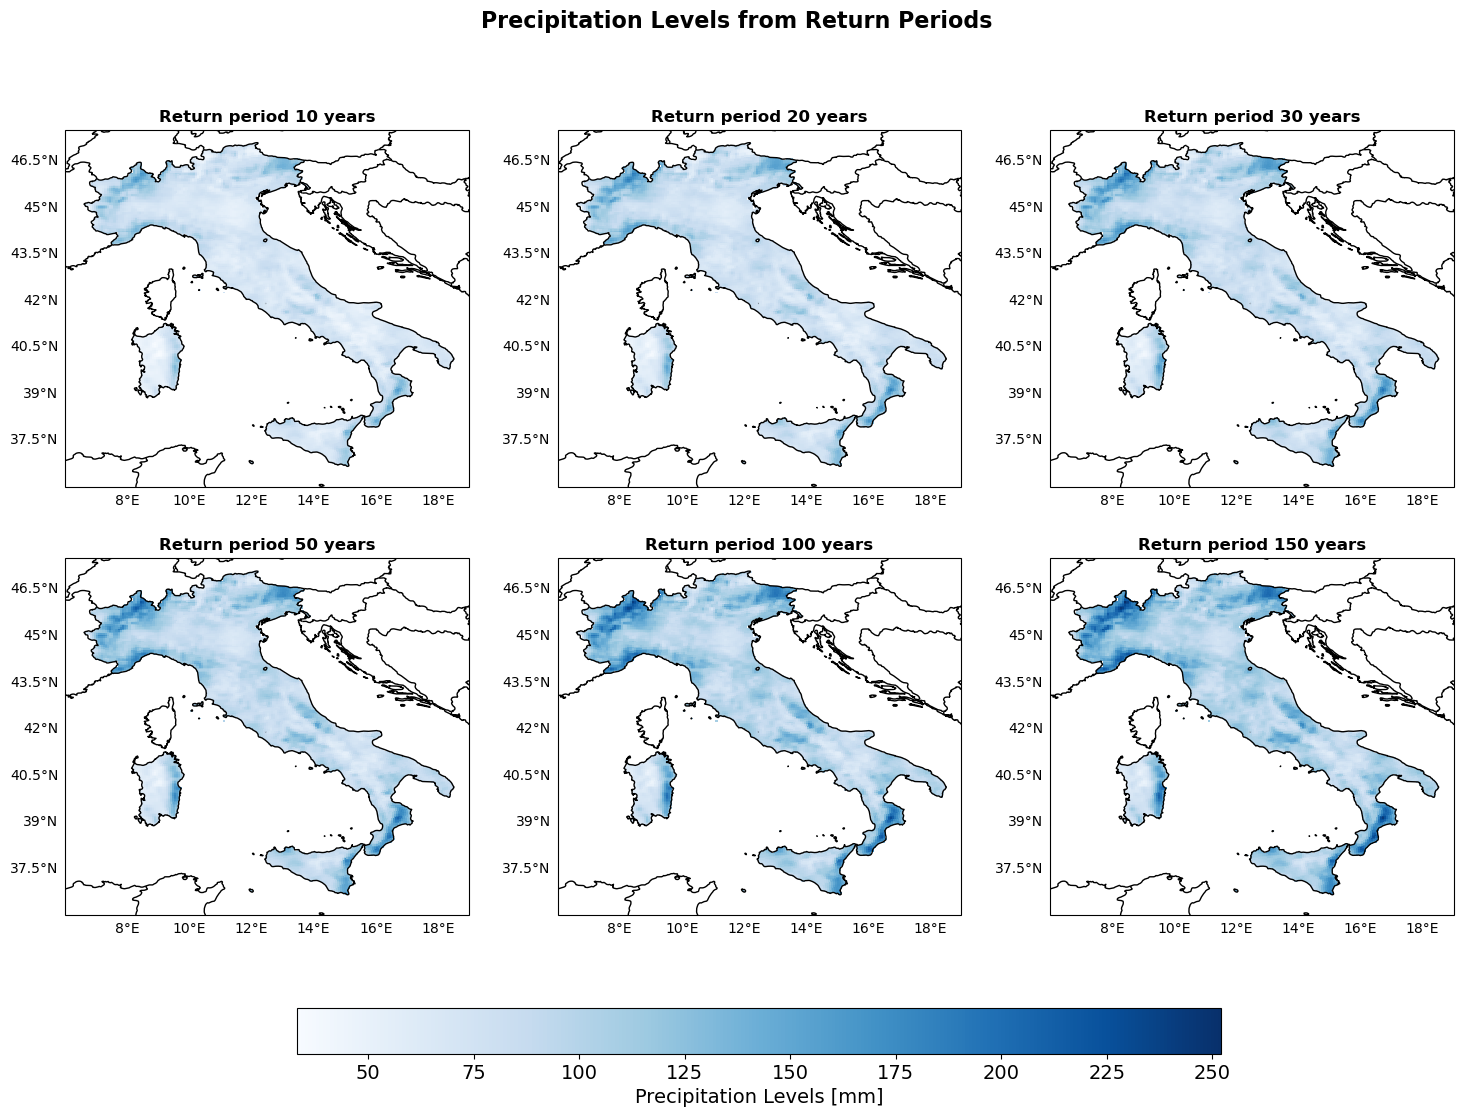

In [18]:
titles_ReturnPeriods = ['Return period 10 years', 'Return period 20 years', 'Return period 30 years',
                        'Return period 50 years', 'Return period 100 years', 'Return period 150 years']

# Create the figure and axis for plotting (1 row, 3 columns)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12), subplot_kw={'projection': ccrs.PlateCarree()})
# Flatten the axes for easier iteration (3x3 grid)
axes = axes.flatten()

# Loop through each masked data array and plot
for i, (mmasked_ReturnPeriod_array, ax, title_ReturnPeriods) in enumerate(zip(mmasked_ReturnPeriod_arrays, axes, titles_ReturnPeriods)):
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black')
    # Add gridlines and format
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.0)
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LongitudeFormatter()
    gl.yformatter = LatitudeFormatter()

    # Plot the masked data
    im = ax.pcolormesh(mmasked_ReturnPeriod_array['longitude'], mmasked_ReturnPeriod_array['latitude'], mmasked_ReturnPeriod_array.values, cmap='Blues', vmin=global_min_ReturnPeriod, vmax=global_max_ReturnPeriod, transform=ccrs.PlateCarree())
    ax.set_title(title_ReturnPeriods, fontweight='bold')

    # Set extent to focus on Italy
    ax.set_extent([6.0, 19.0, 36.0, 47.5], crs=ccrs.PlateCarree())

# Add a colorbar for all plots
cbar = fig.colorbar(im, ax=axes, orientation='horizontal', fraction=0.05, pad=0.1)
cbar.ax.tick_params(labelsize=14)
cbar.set_label('Precipitation Levels [mm]', fontsize=14)
fig.suptitle('Precipitation Levels from Return Periods', fontsize=16, fontweight='bold')
output_fig_path = os.path.join(output_maps, f"UERRA_returnPeriod_comparison.png")
plt.savefig(output_fig_path)
plt.show()